# Testing BIBIMBpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import agama

agama.setUnits(mass = 1, length = 1, velocity = 1)

In [3]:
import bibimbpy

## create initial conditions

In [54]:
r_ic = 4
phi_ic = 0
z_ic = 0
vz_ic = 0

vr_ic = np.linspace(-100,100,100)
vphi_ic = -np.linspace(-400,-100,100)

In [55]:
ic,var1,var2 = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [56]:
ic.shape

(10000, 6)

## Generate axisymmetric potential

In [7]:
pbase = agama.Potential("../../../../Google Drive/My Drive/Recerca/Notebooks/DiscDynamics/Potentials/McMillan17.ini")



## Generate perturbation and its m=0 mode

### generate scaling file

In [8]:
bibimbpy.utils.generate_scaling_file(1,"dehnen",100,"test_scaling_file.txt")

In [9]:
pert_params_dict = {"type":"Ferrers","mass":1e10,"scaleRadius":5,"axisRatioY":0.8,"axisRatioZ":0.2,
                   "scale":"test_scaling_file.txt"}


In [10]:
pot_pertuber = agama.Potential(**pert_params_dict)

scaling_file = pert_params_dict["scale"]

#make the static part
pert_params_dict.pop("scale")
pot_pertuber_static = agama.Potential(**pert_params_dict)
pot_pertuber_m0_static = agama.Potential(type='CylSpline', potential=pot_pertuber_static, 
                                         mmax=0, rmin=0, rmax=20)
pot_pertuber_m0 = agama.Potential(type='CylSpline', potential=pot_pertuber_static, mmax=0, rmin=0, rmax=20, 
                                    scale=bibimbpy.utils.invert_scaling_file(scaling_file))

In [11]:
pbase_m0 = agama.Potential(pbase,pot_pertuber_m0_static)

In [12]:
r_ = np.linspace(0,15,100)
phi_ = np.linspace(0,2*np.pi,100)

R,PHI = np.meshgrid(r_,phi_)

r = R.flatten()
phi = PHI.flatten()

z = np.zeros_like(r)
points = np.column_stack((r*np.cos(phi),r*np.sin(phi),z))
points_line = np.column_stack((r_,r_*0,r_*0))

In [13]:
pm0_stat_eval = pot_pertuber_m0_static.potential(points)

pm0_stat_force = pot_pertuber_m0_static.force(points_line)
pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)

pm0_stat_base_force = pbase_m0.force(points_line)
pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4057661711.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)
/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4057661711.py:7: RuntimeWarning: invalid value encountered in divide
  pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)


In [14]:
t0 = 10

In [15]:
pm0_eval = pot_pertuber_m0.potential(points,t=t0)

pm0_force = pot_pertuber_m0.force(points_line,t=t0)
pm0_omega = np.sqrt(-pm0_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4203405552.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_omega = np.sqrt(-pm0_force[:,0]/r_)


In [16]:
ppert_eval = pot_pertuber.potential(points,t=t0)

ppert_force = pot_pertuber.force(points_line,t=t0)
ppert_omega = np.sqrt(-ppert_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/425372579.py:4: RuntimeWarning: invalid value encountered in divide
  ppert_omega = np.sqrt(-ppert_force[:,0]/r_)


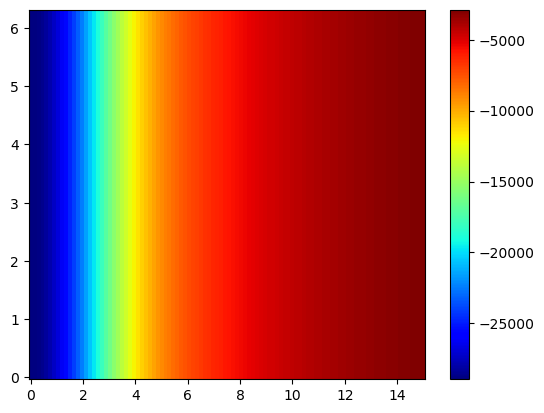

In [17]:
plt.pcolormesh(R,PHI,pm0_stat_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

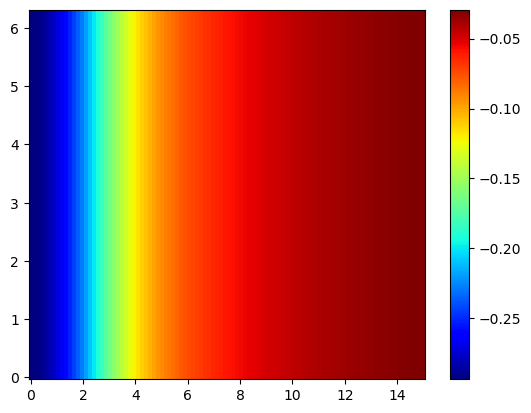

In [18]:
plt.pcolormesh(R,PHI,pm0_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

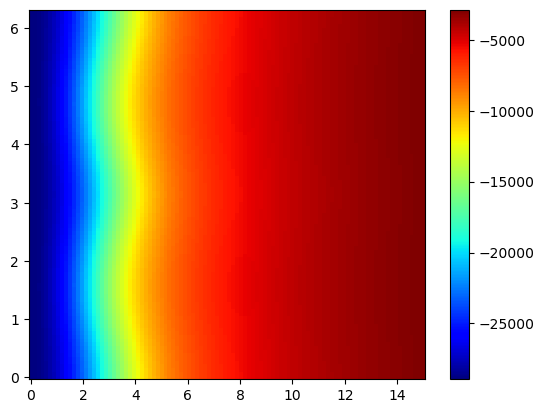

In [19]:
plt.pcolormesh(R,PHI,ppert_eval.reshape(R.shape),cmap="jet")
plt.colorbar()

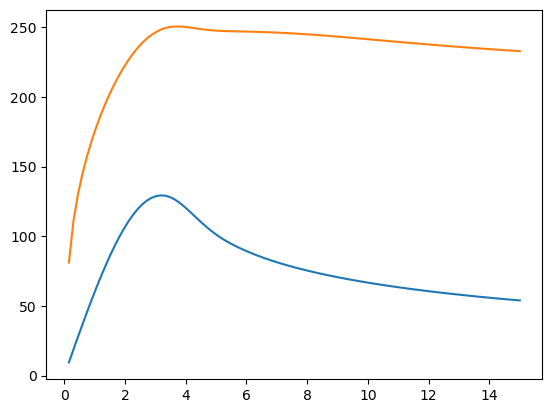

In [20]:
plt.plot(r_,r_*pm0_stat_omega)
plt.plot(r_,r_*pm0_stat_base_omega)

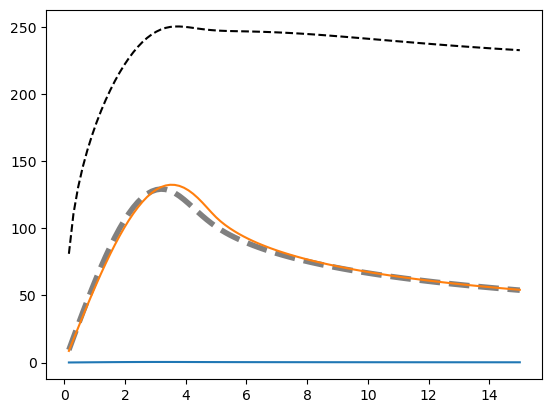

In [21]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*pm0_stat_omega,ls="--",color="grey",lw=4)
plt.plot(r_,r_*pm0_omega)
plt.plot(r_,r_*ppert_omega)

In [22]:
p_timedep = agama.Potential(pbase,pot_pertuber_m0,pot_pertuber)

In [23]:
t = 10

In [24]:
force = p_timedep.force(points_line,t=t)
omega = np.sqrt(-force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/1185998881.py:2: RuntimeWarning: invalid value encountered in divide
  omega = np.sqrt(-force[:,0]/r_)


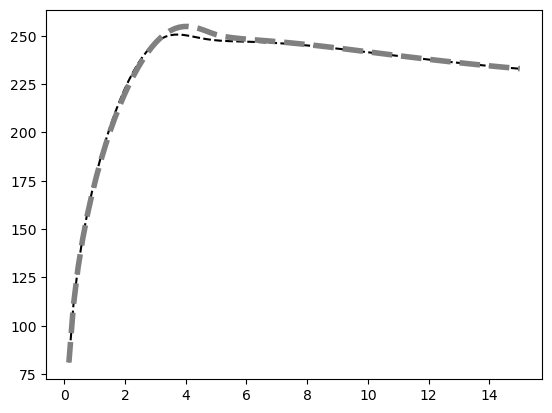

In [25]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*omega,ls="--",color="grey",lw=4)

## Generate DF

In [26]:
paxisym = agama.Potential(pbase,pot_pertuber_m0_static)

In [27]:
df = agama.DistributionFunction(type="QuasiIsothermal", Sigma0 = 1., Rdisk = 2.5, Hdisk = 0.3, 
                                Rsigmar = 5., sigmar0 = 35./np.exp(-8./5.), potential = paxisym)

## Run BI

In [28]:
pattern_speed = 60

In [51]:
force = paxisym.force(points_line)
omega = np.sqrt(-force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/1345282527.py:2: RuntimeWarning: invalid value encountered in divide
  omega = np.sqrt(-force[:,0]/r_)


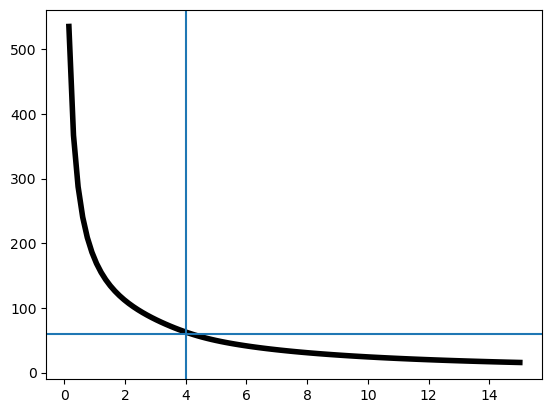

In [53]:
plt.plot(r_,omega,color="k",lw=4)
plt.axhline(pattern_speed)
plt.axvline(4)

In [29]:
Tb = np.abs(2*np.pi/pattern_speed)
print(Tb)

0.10471975511965977


In [70]:
30*Tb

3.141592653589793

In [71]:
df_eval = bibimbpy.orbits.runBI(ic,p_timedep,paxisym,df,Tb,30,pattern_speed)

10000 orbits complete (1e+04 orbits/s)


In [72]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,100)

In [73]:
df_sum.shape

(100, 100)

In [74]:
vre.shape

(101,)

In [75]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

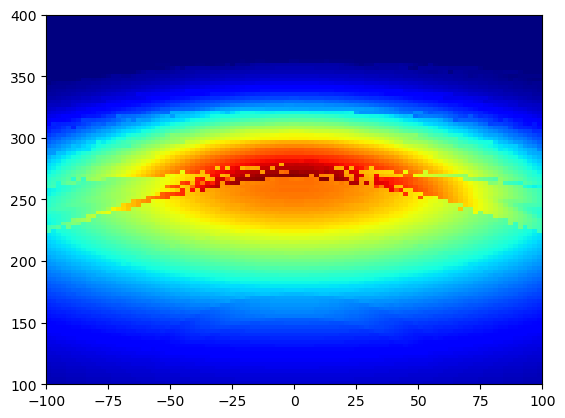

In [76]:
plt.pcolormesh(VR,VPHI,df_sum.T,cmap="jet")

In [36]:
af = agama.ActionFinder(paxisym)

In [37]:
ic

array([[   8.        ,    0.        ,    0.        , -100.        ,
         400.        ,    0.        ],
       [   8.        ,    0.        ,    0.        , -100.        ,
         396.96969697,    0.        ],
       [   8.        ,    0.        ,    0.        , -100.        ,
         393.93939394,    0.        ],
       ...,
       [   8.        ,    0.        ,    0.        ,  100.        ,
         106.06060606,    0.        ],
       [   8.        ,    0.        ,    0.        ,  100.        ,
         103.03030303,    0.        ],
       [   8.        ,    0.        ,    0.        ,  100.        ,
         100.        ,    0.        ]])

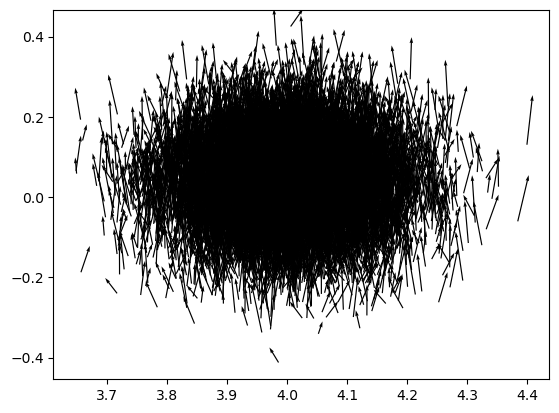

In [77]:
plt.quiver(ic[:,0]+np.random.normal(scale=0.1,size=ic.shape[0]),
           ic[:,1]+np.random.normal(scale=0.1,size=ic.shape[0]),
           ic[:,3],ic[:,4],scale=4000)
#plt.xlim(7.99,8.01)

# Reproduce Dehnen2000

In [4]:
def dehnen_base_pot(R,R0,beta,v0):
    """
    Requires setting up Agama units to 
    agama.setUnits(mass=1, length=R0, velocity=1)
    """
    if beta==0:
        return v0**2*np.log(R/R0)
    else:
        return v0**2/(2*beta)*(R/R0)**(2*beta)

In [5]:
def dehnen_bar_pot(R,phi,Rb,Ab):
    mask_in = R<Rb
    mask_out= R>=Rb
    
    pot = Ab*np.cos(2*phi)*np.ones_like(R)
    
    pot[mask_in] = pot[mask_in]*((R[mask_in]/Rb)**3-2)
    pot[mask_out]= pot[mask_out]*(-(Rb/R[mask_out])**3)
    
    return pot

def get_Ab(t,Af,t1):
    def aux_func(t,t1):
        return 2*t/t1-1
    
    aux = aux_func(t,t1)
    
    return Af*(3/16*aux**5-5/8*aux**3+15/16*aux+1/2)


def get_Af(alfa,v0,R0,Rb):
    return alfa*v0**2/3*(R0/Rb)**3

In [6]:
def get_Rc(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omegab/Omega0)**(1/(beta-1))

def get_Rolr(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omega0/Omegab*(1+np.sqrt((1+beta)/2)))**(1/(1-beta))

def get_omegabar(R0,Rolr,v0,beta):
    Omega0 = v0/R0
    return Omega0*(1+np.sqrt((1+beta)/2))/(Rolr/R0)**(1-beta)

In [7]:
r_ic = 4
phi_ic = 0
z_ic = 0
vz_ic = 0

vr_ic = np.linspace(-100,100,100)
vphi_ic = -np.linspace(-400,-100,100)

In [8]:
ic,var1,var2 = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [9]:
ic.shape

(10000, 6)

In [10]:
## free parameters
R0 = 8
v0 = 240

In [11]:
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)

print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [12]:
params = {"pattern_speed":Omegab,
"r0": R0,
"v0": v0,
"beta": beta,
"sigma0": 1,
"rs": 2.64,
"sigmaR0": 48,
"rsigma": 8}

In [13]:
pbase_params = {"potential":lambda x: dehnen_base_pot(np.sqrt(x[:,0]**2+x[:,1]**2),R0,beta,v0)}

In [14]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",100,"dehnen00_scaling.txt")

In [15]:
pbar_params = {"potential":lambda x: dehnen_bar_pot(np.sqrt(x[:,0]**2+x[:,1]**2),
                                                          np.arctan2(x[:,1],x[:,0]),
                                                          Rb,Af),
              "scale":"dehnen00_scaling.txt"}

In [16]:
timedep_pot,base_pot = bibimbpy.initialize.generate_Pot(pbase_params,pbar_params,_rmin=0.5)

In [17]:
def get_potential(R,params):
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    if beta==0:
        return v0**2*np.log(R/r0)
    else:
        return v0**2/(2*beta)*(R/r0)**(2*beta)

def get_actions(o,params):
    """
    Compute Lz and total Energy
    
    NOTE: Lz must be given in left handed coordinate system for consistency with Denhen DF
    (i.e., Lz will be returned positive for prograde orbits)
    """
    x  = o[:,0]
    y  = o[:,1]
    vx = o[:,3]
    vy = o[:,4]
    
    L = x*vy-y*vx
    E = 0.5*(vx**2+vy**2) + get_potential(np.sqrt(x**2+y**2),params)
    
    return L,E

def obtain_df(L,E,params):
    """
    $$f(E,L) = \frac{\gamma(R_E)\Sigma(R_E)}{2\pi\sigma_R^2(R_E)}exp[\frac{\Omega(R_E)(L-L_c(E))}{\sigma_R^2(R_E)}]$$
    """
    
    RE = get_RE(E,params)
    Lc = get_Lc(E,params)
    
    gamma = get_gamma(RE,params)
    Sigma = get_Sigma(RE,params)
    sigmaR= get_sigmaR(RE,params)
    omega = get_omega(RE,params)
    
    return (gamma*Sigma)/(2*np.pi*sigmaR**2)*np.exp(omega*(L-Lc)/sigmaR**2)

def get_RE(E,params):
    """
    $R_E = R_c(E) = R_0\times\begin{cases}
    [\frac{2\beta E}{v_0^2(1+\beta)}]^{1/(2\beta)} & \text{if } \beta\neq0 \\
    exp(\frac{E}{v_0^2}-\frac{1}{2}) & \text{if } \beta = 0
\end{cases}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    if beta==0:
        return r0*np.exp(E/v0**2-1/2)
    else:
        return r0*((2*beta*E)/(v0**2*(1+beta)))**(1/(2*beta))
    
def get_Lc(E,params):
    """
    $L_c(E) = v_0R_0\times\begin{cases}
    [\frac{2\beta E}{v_0^2(1+\beta)}]^{(1+\beta)/(2\beta)} & \text{if } \beta\neq0 \\
    exp(\frac{E}{v_0^2}-\frac{1}{2}) & \text{if } \beta = 0
\end{cases}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    if beta==0:
        return v0*r0*np.exp(E/v0**2-1/2)
    else:
        return v0*r0*((2*beta*E)/(v0**2*(1+beta)))**((1+beta)/(2*beta))
    
def get_omega(R,params):
    """
    $\Omega(R) = \frac{v_0}{R_0^\beta}R^{\beta-1}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    return v0/r0**(beta)*R**(beta-1)

def get_gamma(R,params):
    """
    $\gamma = \sqrt{\frac{2}{1+\beta}}$
    """
    return np.sqrt(2/(1+params["beta"]))

def get_Sigma(R,params):
    """
    $\Sigma(R) = \Sigma_0exp(-R/R_s)$
    """
    return params["sigma0"]*np.exp(-R/params["rs"])

def get_sigmaR(R,params):
    """
    $\sigma_R(R) = \sigma_0exp(-R/R_\sigma)$
    """
    return params["sigmaR0"]*np.exp(-R/params["rsigma"])

In [18]:
def df_eval_func(points):
    actions = get_actions(points,params)
    L,E = actions
    return obtain_df(L,E,params)

In [ ]:
df_eval = bibimbpy.orbits.runBI(ic,timedep_pot,base_pot,df_eval_func,Tb,t2/Tb,Omegab)